# 2D ultrasound propagation with a planar circular transducer (DPSM)

## Objectives

- Implement the 2D ultrasound propagation in an homogeneous medium according to the Distributed Point Source Method (DPSM) based on Yanagita et al. 2009.
- Evaluate the results of different point sources distributions and choose the one that gives the minimum error compared to the Rayleigh–Sommerfeld analitical solution for the 1D case.
- Study the convergence of the error increasing the number of point sources and choose the optimum one.
- Check the acoustic pressure distribution varying the distance from the transducer.

## Theory

The acoustic propagation for a planar transducer in a homogeneous medium is implemented using the Distributed Point Source Method (DPSM) as in Yanagita et all. 2009.

It comes from an approximation of the Rayleigh integral, with the hypothesis of continuous transducer surface velocity.

The planar tranducer is modeled with a set of point sources uniformly distributed in the transducer surface.
This is possible because, under certain conditions, the acoustic propagation from a point source has an analitical solution. The acoustic pressure generated by the planar transducer in an observation point is approximated to the sum of acoustic pressures generated by the point sources.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import PlanarDiskTransducerSource
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve

## Acoustic source: planar disk transducer

Let's define a planar disk transducer at a given 2D location to represent our acoustic source.

In [2]:
u_z = 1                          # transducer surface velocity (m/s)
c = 1490.0                       # medium speed of sound (m/s) as in Yanagita et al.
rho = 1e3                        # medium density (kg/m3)
r_tr = (2.54e-3) / 2             # transducer radius (m)
x0 = 0                           # transducer location x-axis (m)
y0 = 0                           # transducer location y-axis (m)
z0 = 0                           # transducer location z-axis (m)
freqs = [0.5e6, 1e6, 2e6, 5e6]   # US frequencies
fref = freqs[0]
psources = {Fdrive: PlanarDiskTransducerSource(x0, y0, z0, Fdrive, rho=rho, c=c, r=r_tr) for Fdrive in freqs}

## Transducer surface discretization:  point source distributions

Let's test different way to model the circular transducer with point sources: 
- sunflower
- quadratic
- concentric circles (the one used in Yanagita 2009)

The key feature of all these distribution is the uniformity (needed for the DPS Method). 

At first, we plot the spatial distributions of the point sources. Then, we compare the DPSM resulting acoustic pressures with the analitical solution of the Rayleigh integral for the z-axis (the analitcal solution for the circular transducer is available only for the z axis, the one perpendicular to the transducer surface).

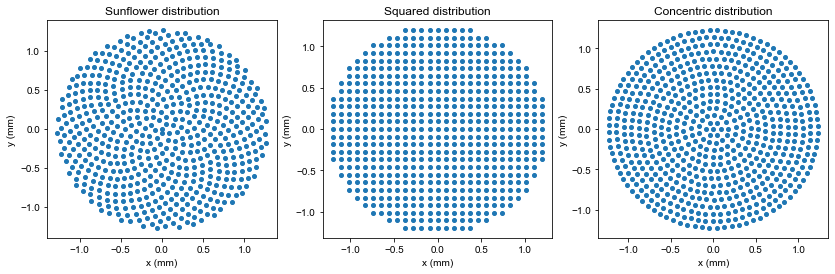

In [4]:
m = 600            # Number of point sources

# Simulate the point sources distributions    
xs, ys = psources[fref].DPSM_sunflowersources(m)    # Sunflower
xq, yq = psources[fref].DPSM_squaredsources(m)      # Squared
xc, yc = psources[fref].DPSM_concentricsources(m)   # Concentric
# Plot the point sources distributions
fig, axes = plt.subplots(1, 3, figsize=(14,4))
ax = axes[0]
ax.set_title('Sunflower distribution')
ax.plot(xs * 1e3, ys * 1e3, 'o', markersize = 4)
ax = axes[1]
ax.set_title('Squared distribution')
ax.plot(xq * 1e3, yq * 1e3, 'o', markersize = 4)
ax = axes[2]
ax.set_title('Concentric distribution')
ax.plot(xc * 1e3, yc * 1e3, 'o', markersize = 4)
for ax in axes:
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')

# Simulate the US amplitude along normal axis
n = 400   # Number of samples in x, z
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m

## Pressure distribution along central propagation axis

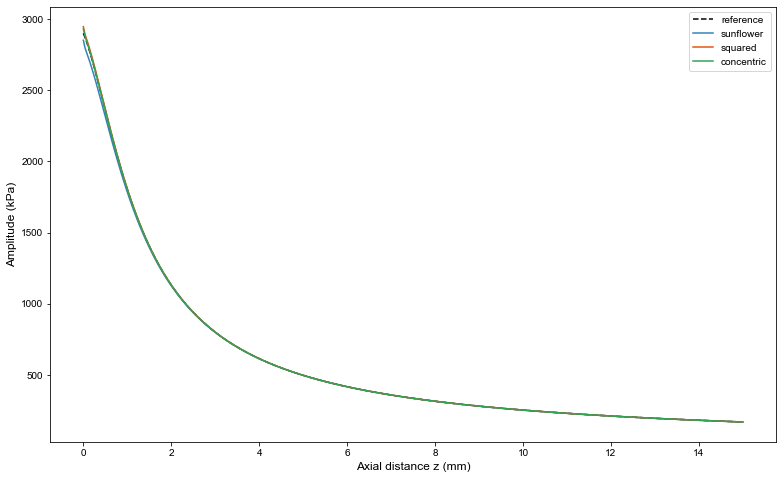

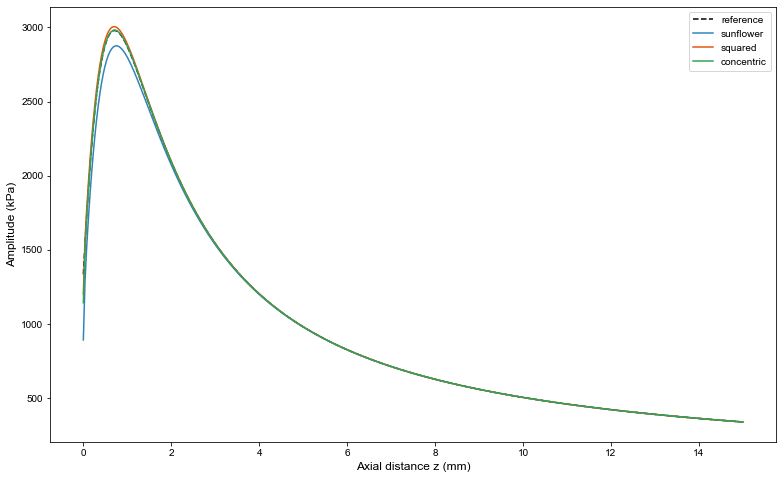

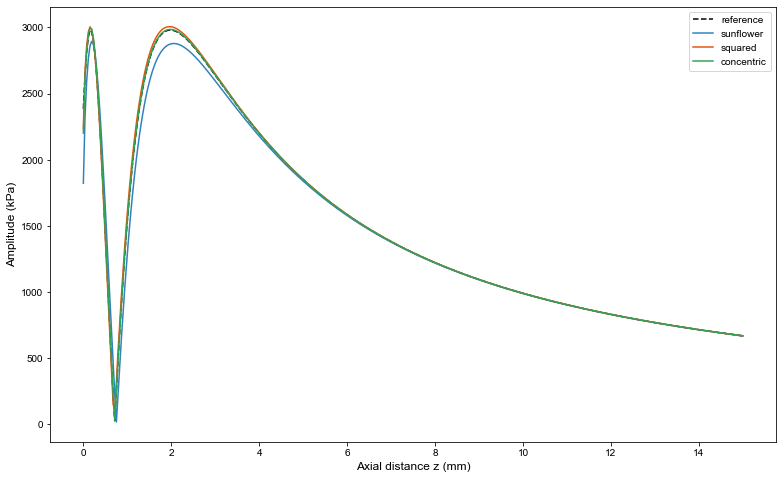

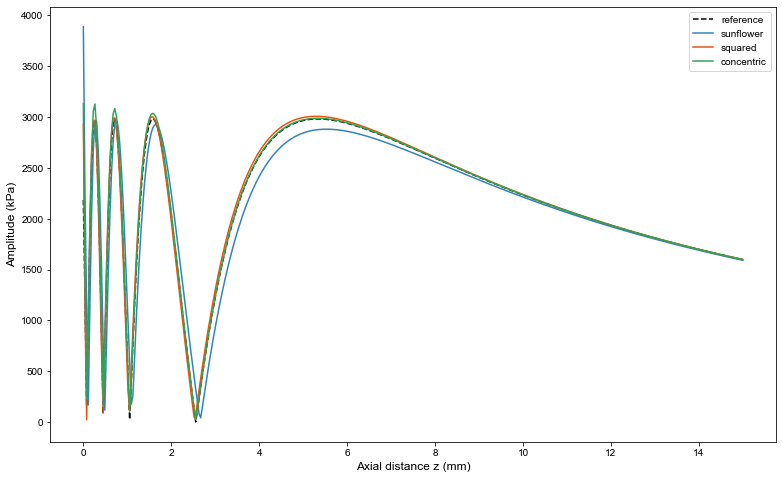

In [5]:
m=800
colors = plt.get_cmap('tab20c').colors

for freq, psource in psources.items():
    
    refamps = psource.normalAxisAmp (z, u_z)
    
    samps = psource.DPSM2d (x, z, u_z, m, 'sunflower')
    qamps = psource.DPSM2d (x, z, u_z, m, 'squared')
    camps = psource.DPSM2d (x, z, u_z, m, 'concentric')
    
    fig, ax = plt.subplots(figsize=(13,8))
    ax.plot(z * 1e3, refamps * 1e-3, label='reference', linestyle='dashed', color='black')
    ax.plot(z * 1e3, samps[int(x.size / 2), :] * 1e-3, label='sunflower', color=colors[0])
    ax.plot(z * 1e3, qamps[int(x.size / 2), :] * 1e-3, label='squared', color=colors[4])
    ax.plot(z * 1e3, camps[int(x.size / 2), :] * 1e-3, label='concentric', color=colors[8])
    ax.set_xlabel('Axial distance z (mm)', fontsize=12)
    ax.set_ylabel('Amplitude (kPa)', fontsize=12)
    ax.legend()

From the figures above we can conclude that:
- At higher frequencies there are some near-field effects.


- The mismatches in the estimation of the acoustic pressure of the circular distributions is mostly in the field near the transducer (low z). 
    At high z the DPSM approximation converges in the analitical solution.


- The concentric distribution seems to be the best in all the z range for low frequencies, and for z > 2 mm for high frequency.

    The squared distribution seems to be the best for high frequency and low z ( z < 2 mm).

    The sunflower distribution seems to be the worst one in all the z range.


At very low z (about 100 nm) our model has a strange behaviour, and since we don't need the very near field, we can consider only the behaviour at z > 100 nm to evaluate the best point sources distribution to use. 
From the plots above we expect that the best distribution would be the concentric one.

### Comparison of different point sources distributions

Compare the resulting acoustic fields along the z direction (the only one for which we have an analitical solution) varying the number of point sources and the frequency of stimulation.
To do that we have to define a cost function: square root of the mean squared error.

In [6]:
# Definition  of the cost function
# Root mean square error from the reference amplitude (along z)
def rmse (x, z, amps, refamps):
    return np.sqrt( sum((amps[int(x.size / 2), :] - refamps)**2) / (len(z))) 

# Calculation of the cost function of the 3 point sources distributions for different m-f combination
mmin = 100
mmax = 2100
mvalues = 11
mtest = np.linspace(mmin, mmax, mvalues)
rmses = np.zeros((mvalues, len(freqs)))
rmseq = np.zeros((mvalues, len(freqs)))
rmsec = np.zeros((mvalues, len(freqs)))
z_cut= z[3:399]
for j, freq in enumerate(freqs):
    refamps = psources[freq].normalAxisAmp (z, u_z)
    refamps_cut = refamps[5:399]
    for i, m in enumerate(mtest):
        samps = psources[freq].DPSM2d (x, z, u_z, m, 'sunflower')
        qamps = psources[freq].DPSM2d (x, z, u_z, m, 'squared')
        camps = psources[freq].DPSM2d (x, z, u_z, m, 'concentric')
        samps_cut = samps[:, 3:399]
        qamps_cut = qamps[:, 3:399]
        camps_cut = camps[:, 3:399]
        rmses[i, j] = rmse (x, z_cut, samps_cut, refamps_cut)
        rmseq[i, j] = rmse (x, z_cut, qamps_cut, refamps_cut)
        rmsec[i, j] = rmse (x, z_cut, camps_cut, refamps_cut)

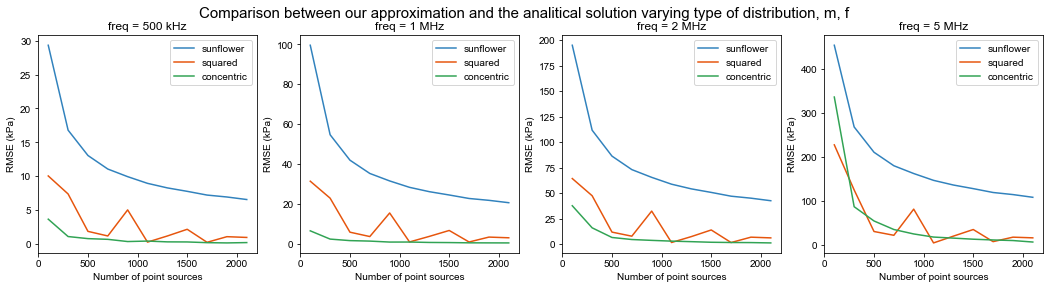

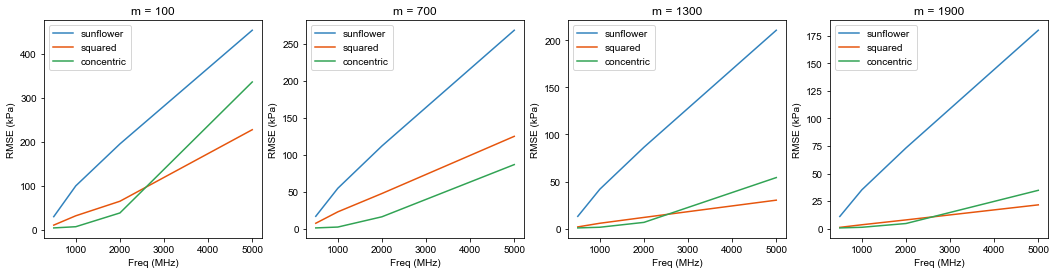

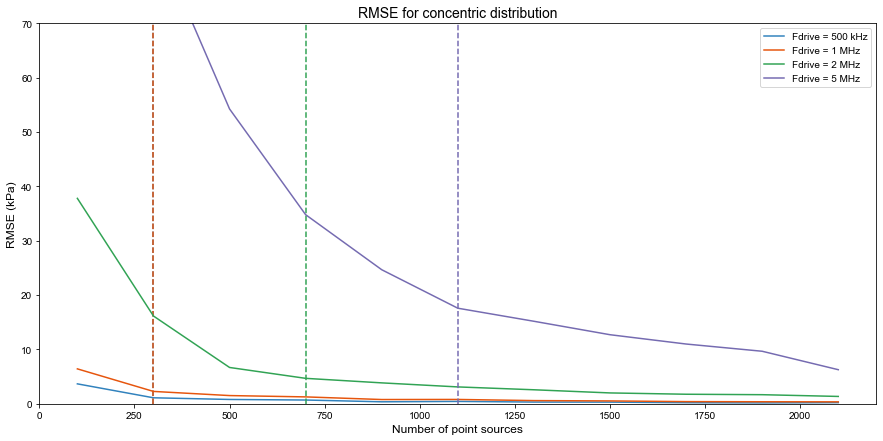

In [7]:
colors = plt.get_cmap('tab20c').colors

def test_sdm(freqs, mtest, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(freqs), figsize=(18, 4))
    for j, f in enumerate(freqs):
        ax = axes[j]
        ax.set_title(f'freq = {si_format(freqs[j])}Hz') 
        ax.plot(mtest, rmses[:,j] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(mtest, rmseq[:,j] * 1e-3, label='squared', color=colors[4])
        ax.plot(mtest, rmsec[:,j] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Number of point sources')
        ax.set_ylabel('RMSE (kPa)')
        ax.legend()
    fig.suptitle('Comparison between our approximation and the analitical solution varying type of distribution, m, f', fontsize=15)
    return fig

def test_sdf(freqs, mvector, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(mvector), figsize=(18, 4))
    f = np.array(freqs) * 1e-3
    for i, m in enumerate(mvector):
        ax = axes[i]
        ax.set_title(f'm = {mvector[i]:.0f}') 
        ax.plot(f, rmses[i,:] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(f, rmseq[i,:] * 1e-3, label='squared', color=colors[4])
        ax.plot(f, rmsec[i,:] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Freq (MHz)')
        ax.set_ylabel('RMSE (kPa)')
        ax.legend()
    return fig
    
fig = test_sdm(freqs, mtest, rmses, rmseq, rmsec)
mvector = [mtest[0], mtest[3], mtest[6], mtest[9]]
fig = test_sdf(freqs, mvector, rmses, rmseq, rmsec)

# Analyse the convergence of RMSE for concentric distribution at different frequencies
# To get a proper value of point sources needed
i = np.zeros(4)
fig, ax = plt.subplots(figsize=(15,7))
for j, f in enumerate(freqs):
    d = 1e4
    while d > 9*1e3:
        d = abs(rmsec[np.int(i[j])+1,j] - rmsec[np.int(i[j]),j])
        i[j]= i[j]+1
    ax.plot(mtest, rmsec[:,j] * 1e-3, color = colors[4*j], label = f'Fdrive = {si_format(f)}Hz')
    ax.axvline(x=mtest[np.int(i[j])], linestyle='dashed', color=colors[4*j])
ax.set_ylim((0,70))
ax.set_title('RMSE for concentric distribution', fontsize=14)
ax.set_xlabel('Number of point sources', fontsize=12)
ax.set_ylabel('RMSE (kPa)', fontsize=12)
ax.legend()

From the figures above we can conclude that: 
- Increasing the frequency increase also the error. 


- The best point sources distribution is the concentric one, given the lower error and the smoothness of the curve. This is in accordance with the visual observations we made before. 

    The squared distribution has good performance too and the same convergence value, but it is more discountinuous.

    The sunflower distribution has the worst performance for each frequency and each number of point sources, and show an higher convergence value comparing to the other two distributions. This may be due to the non-uniformity that we see in the centre of the spatial distribution and this hypothesis agrees with the observation that the mismatch with the analitical solution is higher for low z values. 


- Considering the concentric distribution, the number of point sources at which we reach the convergence depends on the frequency. To decide the number of point sources to be used we need a trade off between the error and the computational complexity of the model. So we highligth the elbow points (increasing from these points will give a low improvement): for 500 kHz and 1 MHz is around 300, for 2 MHz 700, for 5 MHz 1100. We can use the maximum one (1100) to be sure to obtain a good approximation at each frequency. 

    To generalize the result and to use it for transducer of every shape and dimension, we can use the equivalent density: 217 point sources / mm^2 . From now on we are going to use this density to model US transducers (it garantees good results at a maximum frequency of 5 MHz).

## 2D acoustic field

### Naive approach

Let's compute the 2D acoustic pressure distribution generated by the transducer:

Max amplitude: Amax = 3 MPa
Max amplitude: Amax = 3 MPa
Max amplitude: Amax = 4 MPa
Max amplitude: Amax = 8 MPa


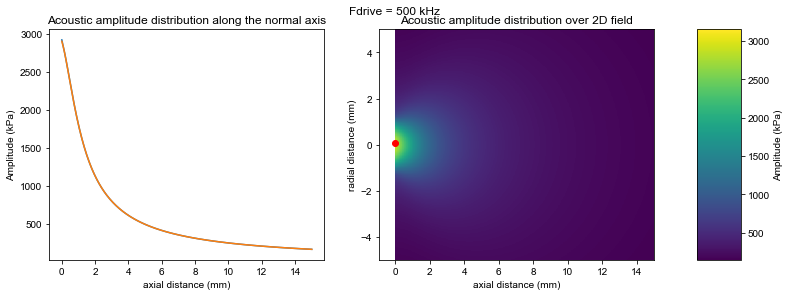

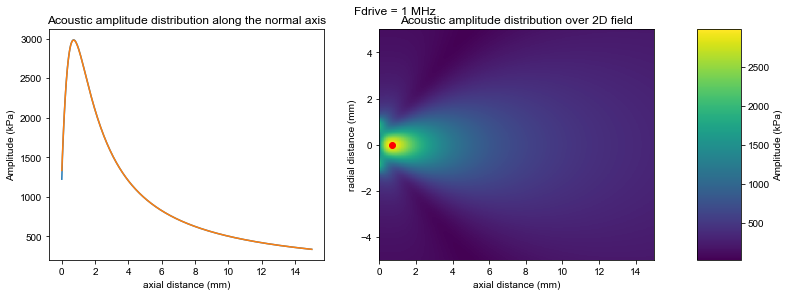

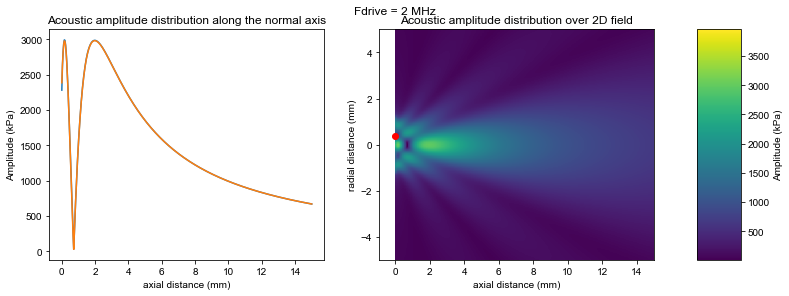

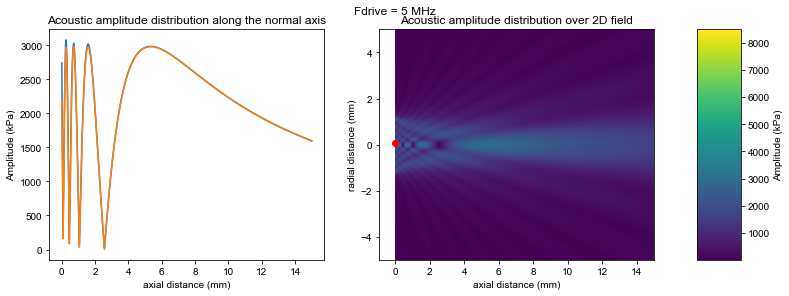

In [10]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    
    imax = np.unravel_index(np.nanargmax(amps, axis=None), amps.shape)
    xmax, zmax = x[imax[0]], z[imax[1]]
    assert np.nanmax(amps) == amps[imax[0], imax[1]]
    ax.scatter(zmax * 1e3, xmax * 1e3, c='r')
    print(f'Max amplitude: Amax = {si_format(amps.max())}Pa')
    
    return fig

# Generate 2D square grid
n = 400
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m
xx, zz = np.meshgrid(x, z)

m = 1100   # number of point sources at which we reach convergence

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM2d (x, z, u_z, m, 'concentric')  # Pa
    refamps = psources[Fdrive].normalAxisAmp (z, u_z)
    fig = plotAmpDist(x, z, amps, refamps)
    fig.suptitle(f'Fdrive = {si_format(Fdrive)}Hz', fontsize=12)

The color plots of the 2D acoustic pressure at high frequencies (2 MHz, 5 MHz) suggest some very high values of pressure (around 8 MPa, see printed values) at very low z.

It can be a discretization artefact at very low z (comparable to the distance between point sources), and we could expect it.

### Visualisation of discretization artefacts in the near-field

We want to visualise this discretization error. To do that we plot the pressure for the xy slices at low z to access the location of these maxima and the depth at which these high values disappear.

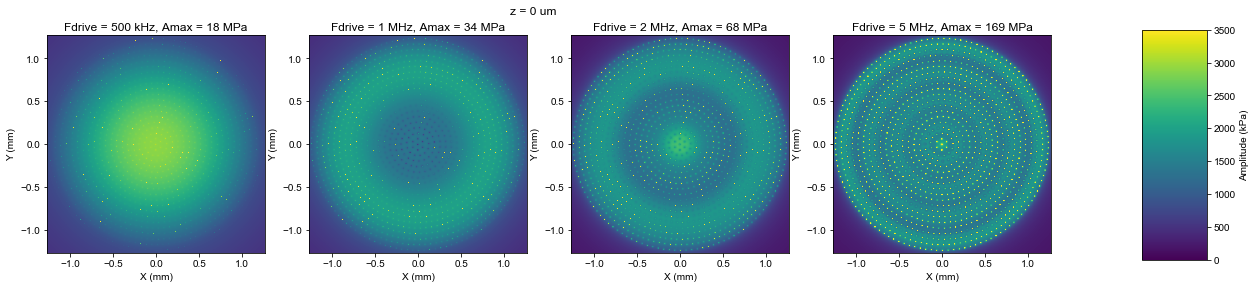

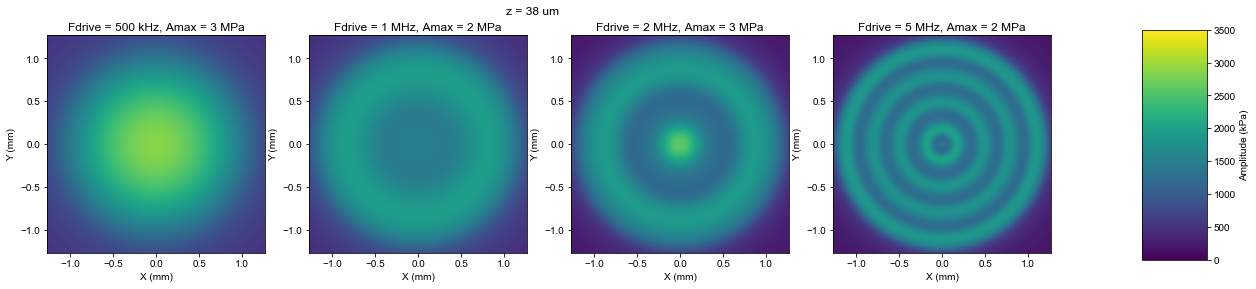

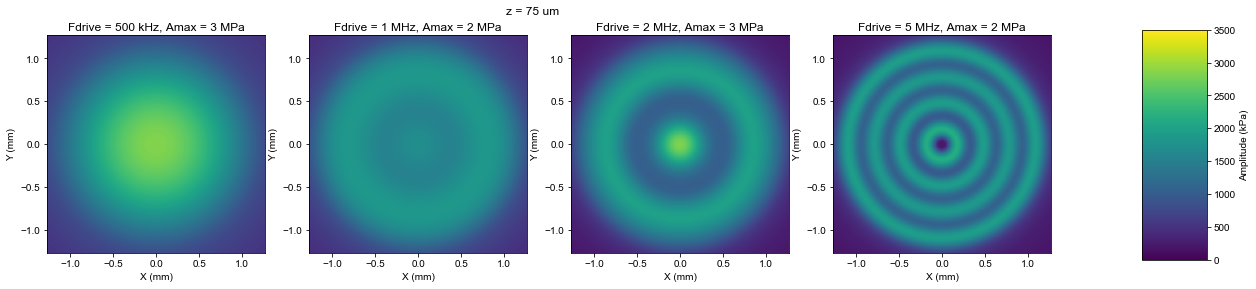

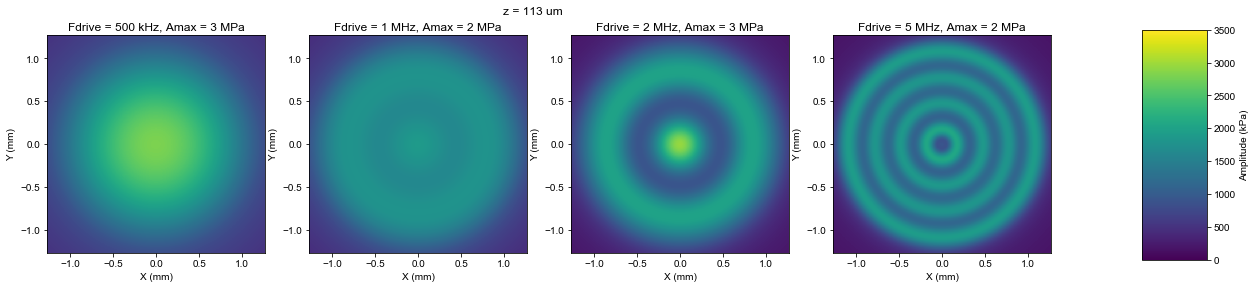

In [12]:
z = np.linspace(0, 0.015, 400)  # m
x = np.linspace(-r_tr, r_tr, 600)  # m
y = np.linspace(-r_tr, r_tr, 600)  # m

m=1100
for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for j, Fdrive in enumerate(freqs):
        ax = axes[j]
        amps = psources[Fdrive].DPSMxy (x, y, z[i], u_z, m, 'concentric')  # Pa
        ax.set_title(f'Fdrive = {si_format(Fdrive)}Hz, Amax = {si_format(amps.max())}Pa', fontsize=12)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        sm = ax.pcolormesh(x * 1e3, y * 1e3, amps * 1e-3, cmap='viridis', vmin=0, vmax=3500)
    cbarax = fig.add_axes([0.97, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    fig.suptitle(f'z = {si_format(z[i]*1e6)}um')

- The maxima are located on the point sources, it confirms that this is a discretization artefact.


- The max initial values of pressure seems to depend on frequency: higher the frequency higher the initial value.


- The ultrasound field seems ok from the second slice. 

Studying the dependencies of the max initial values is difficult because they are very local and decrease fastly, so the max value we achieve highly depends on the grid xy on which we are computing the ultrasound field. Moreover, we don't really need to estimate this max value: what we really need for our model is the depth required to get the right range of pressures.

We want to verify if the depth depend also on the number of point sources, density of point sources or dimension of the transducer surface. So in the next tests we are going to separate these variables to identify the real dependencies.

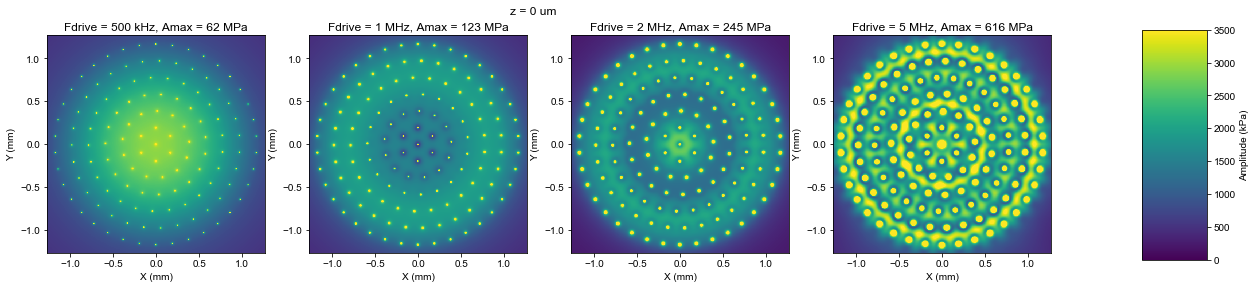

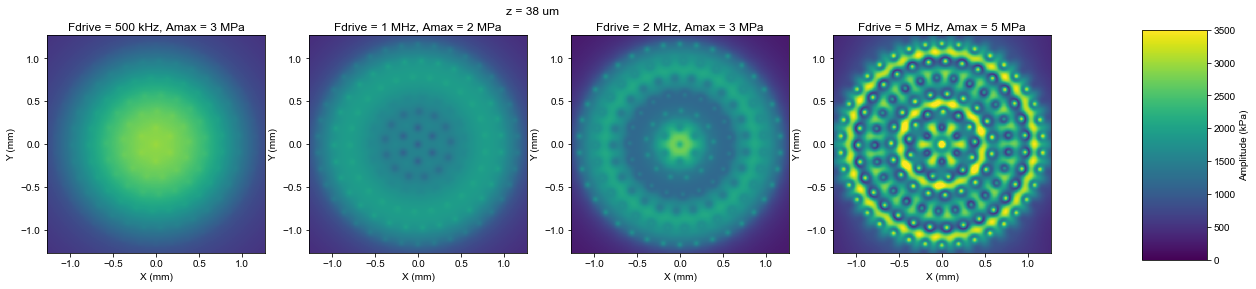

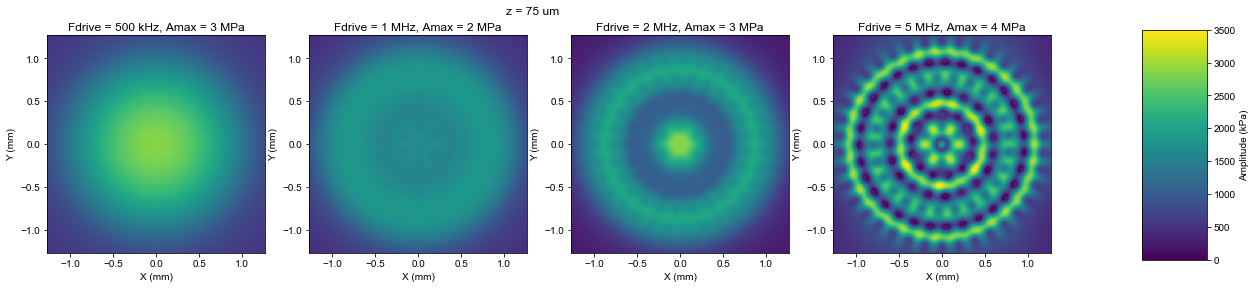

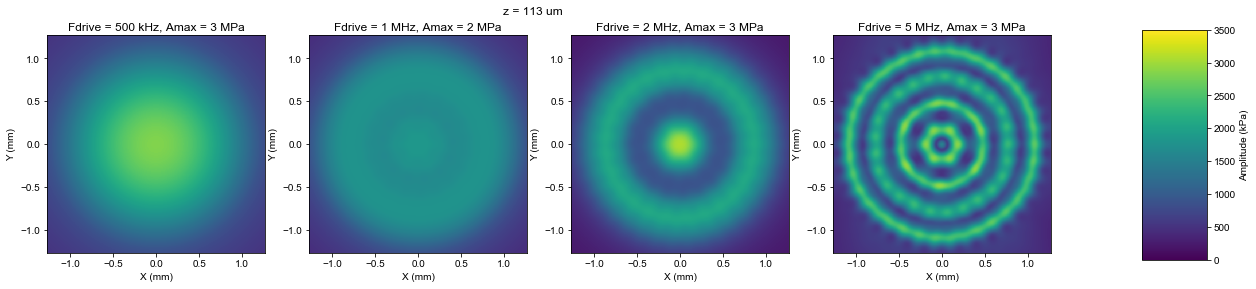

In [14]:
# Same transducer surface, lower number of point sources
# Lower density of point sources

z = np.linspace(0, 0.015, 400)  # m
x = np.linspace(-r_tr, r_tr, 600)  # m
y = np.linspace(-r_tr, r_tr, 600)  # m

m=100
for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for j, Fdrive in enumerate(freqs):
        ax = axes[j]
        amps = psources[Fdrive].DPSMxy (x, y, z[i], u_z, m, 'concentric')  # Pa
        ax.set_title(f'Fdrive = {si_format(Fdrive)}Hz, Amax = {si_format(amps.max())}Pa', fontsize=12)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        sm = ax.pcolormesh(x * 1e3, y * 1e3, amps * 1e-3, cmap='viridis', vmin=0, vmax=3500)
    cbarax = fig.add_axes([0.97, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    fig.suptitle(f'z = {si_format(z[i]*1e6)}um')

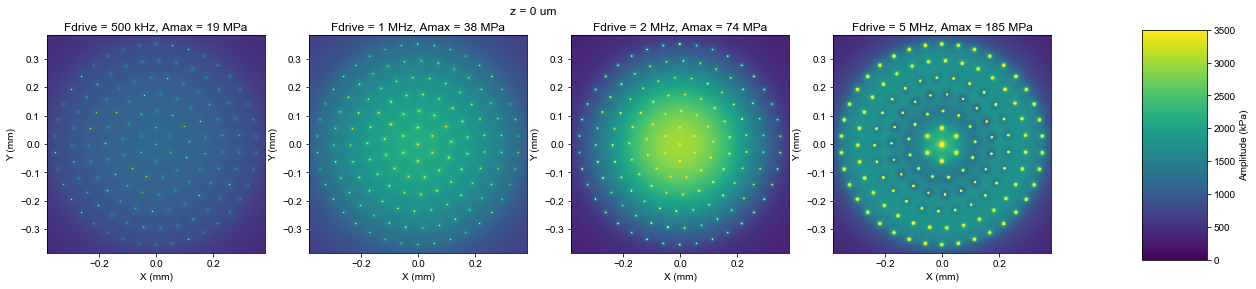

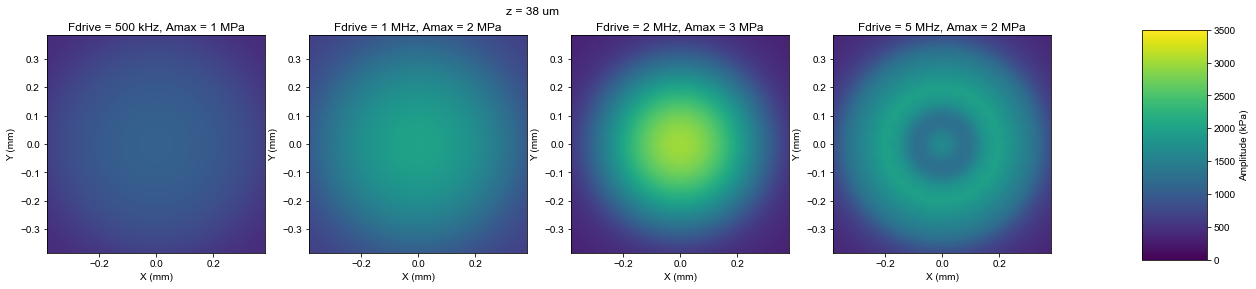

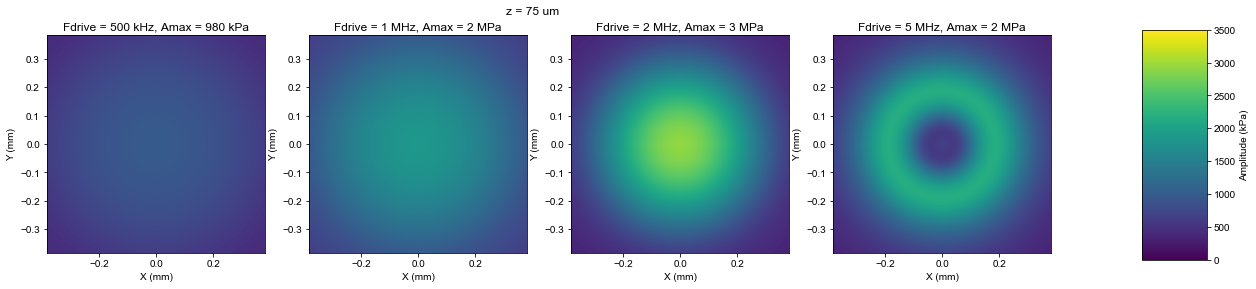

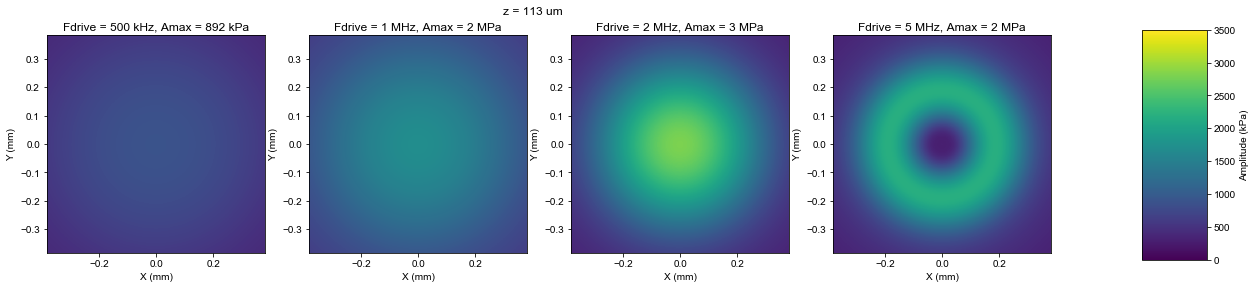

In [15]:
# Lower transducer surface, lower number of point sources
# Same density of point sources (comparing to the first trial)

density = 217e6  # point sources / m^2
m=100
radius = np.sqrt (m / (density *np.pi))  # m
psources = {Fdrive: PlanarDiskTransducerSource(x0, y0, z0, Fdrive, rho=rho, c=c, r=radius) for Fdrive in freqs}
z = np.linspace(0, 0.015, 400)  # m
x = np.linspace(-radius, radius, 600)  # m
y = np.linspace(-radius, radius, 600)  # m

for i in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for j, Fdrive in enumerate(freqs):
        ax = axes[j]
        amps = psources[Fdrive].DPSMxy (x, y, z[i], u_z, m, 'concentric')  # Pa
        ax.set_title(f'Fdrive = {si_format(Fdrive)}Hz, Amax = {si_format(amps.max())}Pa', fontsize=12)
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        sm = ax.pcolormesh(x * 1e3, y * 1e3, amps * 1e-3, cmap='viridis', vmin=0, vmax=3500)
    cbarax = fig.add_axes([0.97, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    fig.suptitle(f'z = {si_format(z[i]*1e6)}um')

The US field at very low z is highly dependent on the specific point source distribution chosen, so it is not reliable and useful for any application.

From the results above, we can assert that the depth required to get the right range of pressures depends on the frequency and the density of point sources:
- Higher is the frequency, thicker is the layer to be removed
- Higher is the density of point sources, thinner is the layer to be removed


Considering the density of point sources fixed at 217 point sources / mm^2, the results are reliable up to 5 MHz removing the very first layer of about 100 um (3 samples for our z-axis resolution).

### Refined visualisation (discretization artefacts removed)

Max amplitude: Amax = 3 MPa
Max amplitude: Amax = 3 MPa
Max amplitude: Amax = 3 MPa
Max amplitude: Amax = 3 MPa


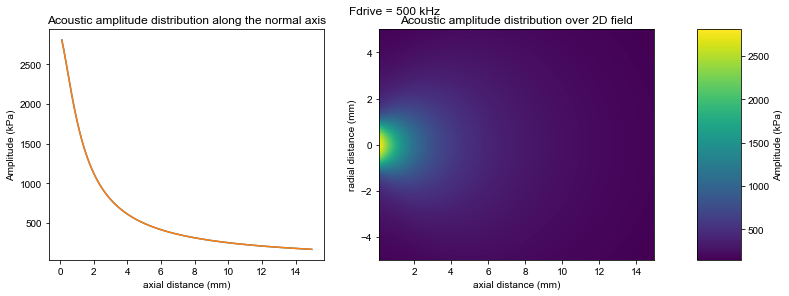

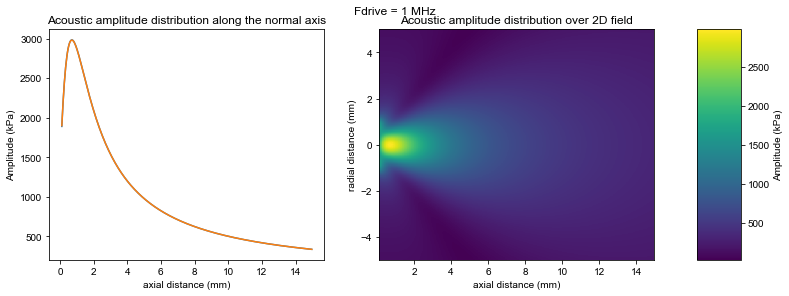

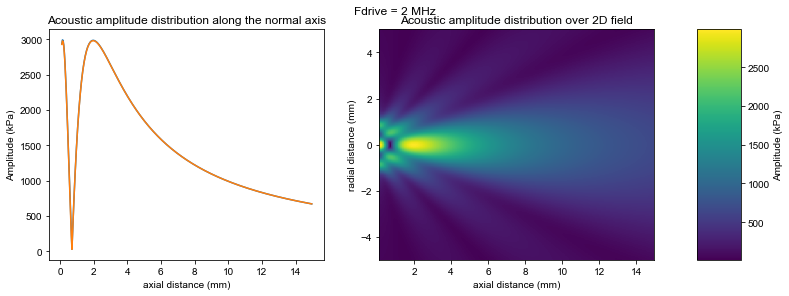

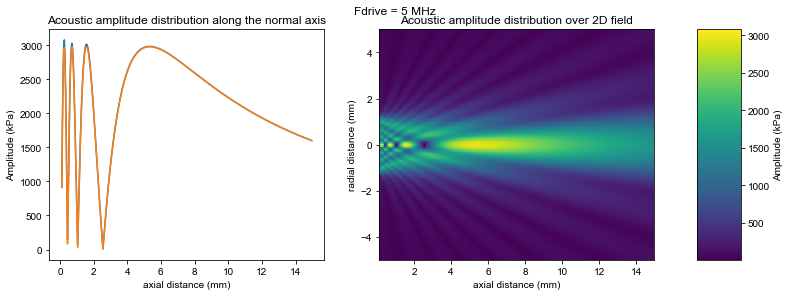

In [16]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    print(f'Max amplitude: Amax = {si_format(amps.max())}Pa')   
    return fig

# Generate 2D square grid
n = 400
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m
xx, zz = np.meshgrid(x, z)

psources = {Fdrive: PlanarDiskTransducerSource(x0, y0, z0, Fdrive, rho=rho, c=c, r=r_tr) for Fdrive in freqs}
m = 1100   # number of point sources at which we reach convergence

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM2d (x, z, u_z, m, 'concentric')  # Pa
    refamps = psources[Fdrive].normalAxisAmp (z, u_z)
    amps_cut = amps[:, 3:399]
    refamps_cut = refamps[3:399]
    z_cut = z [3:399]
    fig = plotAmpDist(x, z_cut, amps_cut, refamps_cut)
    fig.suptitle(f'Fdrive = {si_format(Fdrive)}Hz', fontsize=12)

Now the ultrasound fields are in the correct range of values: we have correctly removed the artifacts.


As we can see, for higher frequencies we have:
- Higher directionality 


- Higher near-field effect

### Acoustic distribution along fiber

Let's check the resulting acoustic pressure distribution at different distances from the transducer. 

This can be useful to visualise the pressure that would affect a fiber placed orthogonally to the acoustic propagation axis.

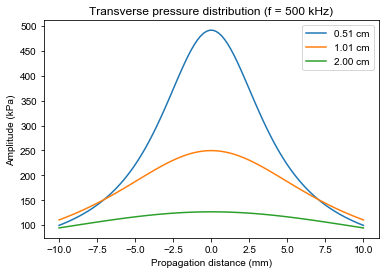

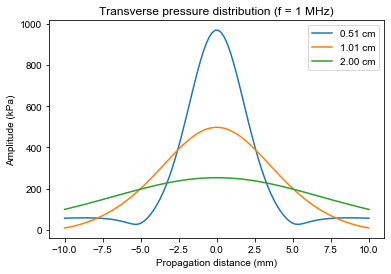

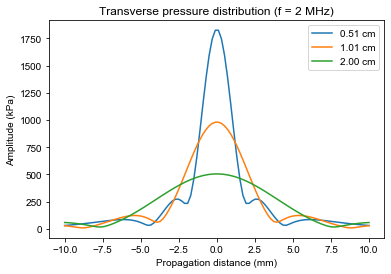

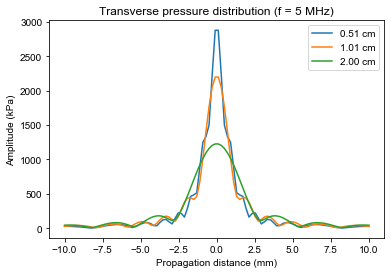

In [17]:
def plotTransverseAmpDist(Fdrive, x, z, amps, index):
    fig, ax = plt.subplots()
    ax.set_title(f'Transverse pressure distribution (f = {si_format(Fdrive)}Hz)')
    ax.set_xlabel('Propagation distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    for i in range(len(index)):
        lbl = f'{(z[index[i]] * 1e2):.2f} cm'
        ax.plot(x * 1e3, amps[:,index[i]] * 1e-3, c=f'C{i}', label=lbl)
    ax.legend()
    return fig

m = 1100
n = 100
x = np.linspace(-1e-2, 1e-2, n)
z = np.linspace(0, 0.02, n)  # m
index = [25, 50, 99]
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM2d(x, z, u_z, m, 'concentric')  # Pa
    plotTransverseAmpDist(Fdrive, x, z, amps, index)

Higher frequency means higher peak pressure amplitude and more selective field. 

## Conclusions
We obtain the 2D ultrasound propagation for a planar circular transducer in a homogeneous medium validated on the Yanagita et al. 2009 paper results.

Features of the DPSM tranducer model: 
- Type of point sources distribution: concentric 
- Point source density (frequency garantee under 5MHz): around 217 point sources / mm^2
- Depth of the initial layer removed: 150 nm

## References
- Yanagita T., Kundu T., Placko D., "Ultrasonic field modeling by distributed point source method for different transducer boundary conditions.", J. Acoust. Soc. Am. 2009 Nov; 126(5):2331-9. doi: 10.1121/1.3203307. https://bit.ly/2kiNwaS


- Cheng J., Lin W., Qin Y., " Extension of the distributed point source method for ultrasonic field modeling", Ultrasonics 2010.

